# Improving Performance: Optimizing the membrane time constant

In this notebook I investigate if changing the membrane time constant improves performance.

**tl;dr** Test accuracy drastically increases for decreasing membrane time constant. Learned weights seem to have a different structure than previous notebooks. Future work may want to learn the optimial membrane time constant jointy with the synaptic weights. 

Currently working on this: Zachary Friedenberger

In [80]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn

dtype = torch.float

from tqdm import trange

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
my_computer_is_slow = True # set this to True if using Colab

## Sound localization stimuli

The following function creates a set of stimuli that can be used for training or testing. We have two ears (0 and 1), and ear 1 will get a version of the signal delayed by an IPD we can write as $\alpha$ in equations (``ipd`` in code). The basic signal is a sine wave as in the previous notebook, made positive, so $(1/2)(1+\sin(\theta)$. In addition, for each ear there will be $N_a$ neurons per ear (``anf_per_ear`` because these are auditory nerve fibres). Each neuron generates Poisson spikes at a certain firing rate, and these Poisson spike trains are independent. In addition, since it is hard to train delays, we seed it with uniformly distributed delays from a minimum of 0 to a maximum of $\pi/2$ in each ear, so that the differences between the two ears can cover the range of possible IPDs ($-\pi/2$ to $\pi/2$). We do this directly by adding a phase delay to each neuron. So for ear $i\in\{0,1\}$ and neuron $j$ at time $t$ the angle $\theta=2\pi f t+i\alpha+j\pi/2N_a$. Finally, we generate Poisson spike trains with a rate $R_\mathrm{max}((1/2)(1+\sin(\theta)))^k$. $R_\mathrm{max}$ (``rate_max``) is the maximum instantaneous firing rate, and $k$ (``envelope_power``) is a constant that sharpens the envelope. The higher $R_\mathrm{max}$ and $k$ the easier the problem (try it out on the cell below to see why).

Here's a picture of the architecture for the stimuli:

![Stimuli architecture](diagrams/arch-stimuli.png)

The functions below return two arrays ``ipd`` and ``spikes``. ``ipd`` is an array of length ``num_samples`` that gives the true IPD, and ``spikes`` is an array of 0 (no spike) and 1 (spike) of shape ``(num_samples, duration_steps, 2*anf_per_ear)``, where ``duration_steps`` is the number of time steps there are in the stimulus.

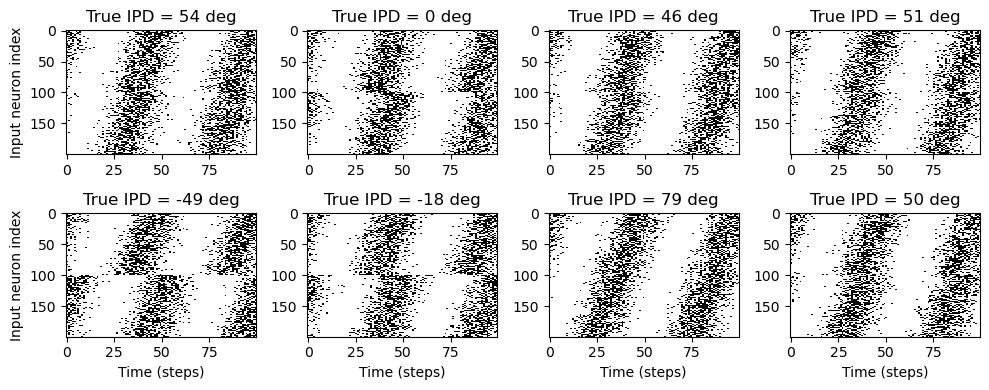

In [21]:
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # repeats of each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes, easier
rate_max = 600*Hz   # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    num_samples = len(ipd)
    T = np.arange(duration_steps)*dt # array of times
    phi = 2*np.pi*(f*T+np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, anf_per_ear)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear)<rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, tensor=True):
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

# Plot a few just to show how it looks
ipd, spikes = random_ipd_input_signal(8)
spikes = spikes.cpu()
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

Now the aim is to take these input spikes and infer the IPD. We can do this either by discretising and using a classification approach, or with a regression approach. For the moment, let's try it with a classification approach.

## Classification approach

We discretise the IPD range of $[-\pi/2, \pi/2]$ into $N_c$ (``num_classes``) equal width segments. Replace angle $\phi$ with the integer part (floor) of $(\phi+\pi/2)N_c/\pi$. We also convert the arrays into PyTorch tensors for later use. The algorithm will now guess the index $i$ of the segment, converting that to the midpoint of the segment $\phi_i=a+(i+1/2)(b-a)/N_c$ when needed.

The algorithm will work by outputting a length $N_c$ vector $y$ and the index of the maximum value of y will be the guess as to the class (1-hot encoding), i.e. $i_\mathrm{est}=\mathrm{argmax}_i y_i$. We will perform the training with a softmax and negative loss likelihood loss, which is a standard approach in machine learning.

In [22]:
# classes at 15 degree increments
num_classes = 180//15
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


In [23]:
# Weights and uniform weight initialisation
def init_weight_matrix():
    # Note that the requires_grad=True argument tells PyTorch that we'll be computing gradients with
    # respect to the values in this tensor and thereby learning those values. If you want PyTorch to
    # learn some gradients, make sure it has this on.
    W = nn.Parameter(torch.empty((input_size, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    return W

# Run the simulation
def membrane_only(input_spikes, W, tau=20*ms):
    # Input has shape (batch_size, duration_steps, input_size)
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    # v_rec will store the membrane in each time step
    v_rec = [v]
    # Batch matrix multiplication all time steps
    # Equivalent to matrix multiply input_spikes[b, :, :] x W for all b, but faster
    h = torch.einsum("abc,cd->abd", (input_spikes, W))
    # precalculate multiplication factor
    alpha = np.exp(-dt/tau)
    # Update membrane and spikes one time step at a time
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    # return the recorded membrane potentials stacked into a single tensor
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec

### Training

We train this by dividing the input data into batches and computing gradients across batches. In this notebook, batch and data size is small so that it can be run on a laptop in a couple of minutes, but normally you'd use larger batches and more data. Let's start with the data.

In [24]:
# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

Now we run the training. We generate the training data, initialise the weight matrix, set the training parameters, and run for a few epochs, printing the training loss as we go. We use the all-powerful Adam optimiser, softmax and negative log likelihood loss.

### Analysis of results

Now we compute the training and test accuracy, and plot histograms and confusion matrices to understand the errors it's making.

In [125]:
def analyse(ipds, spikes, label, run, plot=False):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    #print()
    #print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    #print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    if plot==True:
        
        print()
        print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
        print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")
    
        plt.figure(figsize=(10, 4), dpi=100)
        plt.subplot(121)
        plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
        plt.hist(ipd_est*180/np.pi, bins=num_classes, label='Estimated')
        plt.xlabel("IPD")
        plt.yticks([])
        plt.legend(loc='best')
        plt.title(label)
        plt.subplot(122)
        confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
        plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
        plt.xlabel('True IPD')
        plt.ylabel('Estimated IPD')
        plt.title('Confusion matrix')
        plt.tight_layout()
    
    return 100*np.mean(accs)

This poor performance isn't surprising because this network is not actually doing any coincidence detection, just a weighted sum of input spikes.

## Spiking model

Next we'll implement a version of the model with spikes to see how that changes performance. We'll just add a single hidden feed-forward layer of spiking neurons between the input and the output layers. This layer will be spiking, so we need to use the surrogate gradient descent approach.

![Full architecture](diagrams/arch-full.png)

### Surrogate gradient descent

First, this is the key part of surrogate gradient descent, a function where we override the computation of the gradient to replace it with a smoothed gradient. You can see that in the forward pass (method ``forward``) it returns the Heaviside function of the input (takes value 1 if the input is ``>0``) or value 0 otherwise. In the backwards pass, it returns the gradient of a sigmoid function.

In [27]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply

### Updated model

The code for the updated model is very similar to the membrane only layer. First, for initialisation we now need two weight matrices, $W_1$ from the input to the hidden layer, and $W_2$ from the hidden layer to the output layer. Second, we run two passes of the loop that you saw above for the membrane only model.

The first pass computes the output spikes of the hidden layer. The second pass computes the output layer and is exactly the same as before except using the spikes from the hidden layer instead of the input layer.

For the first pass, we modify the function in two ways.

Firstly, we compute the spikes with the line ``s = spike_fn(v-1)``. In the forward pass this just computes the Heaviside function of $v-1$, i.e. returns 1 if $v>1$, otherwise 0, which is the spike threshold function for the LIF neuron. In the backwards pass, it returns a gradient of the smoothed version of the Heaviside function.

The other line we change is the membrane potential update line. Now, we multiply by $1-s$ where ($s=1$ if there was a spike in the previous time step, otherwise $s=0$), so that the membrane potential is reset to 0 after a spike (but in a differentiable way rather than just setting it to 0).

In [28]:
num_hidden = 30

# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

# Run the simulation
def snn(input_spikes, W1, W2, tau=20*ms):
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    # Return recorded membrane potential of output
    return v_rec

### Training and analysing

We train it as before, except that we modify the functions to take the two weight matrices into account.

In [124]:
def train_snn(tau_m, num_epochs=10):

    # Training parameters
    #nb_epochs = 10 # quick, it won't have converged
    lr = 0.01 # learning rate

    # Generate the training data
    ipds, spikes = random_ipd_input_signal(num_samples)

    # Initialise a weight matrices
    W1, W2 = init_weight_matrices()

    # Optimiser and loss function
    optimizer = torch.optim.Adam([W1, W2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    #tau_m = 5*ms

    #print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, W1, W2, tau=tau_m)
            # Compute cross entropy loss
            m = torch.mean(output, 1)  # Mean across time dimension
            loss = loss_fn(log_softmax_fn(m), y_local)
            local_loss.append(loss.item())
            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))
        #print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

    # Plot the loss function over time
    #plt.plot(loss_hist)
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.title(tau_m)
    #plt.tight_layout()
    
    return W1, W2, loss_hist

You might already see that the loss functions are lower than before, so maybe performance is better? Let's see.

Chance accuracy level: 8.3%

Train classifier accuracy: 91.0%
Train absolute error: 4.2 deg
torch.Size([4096, 100, 200])

Test classifier accuracy: 76.5%
Test absolute error: 5.1 deg
torch.Size([2048, 100, 200])


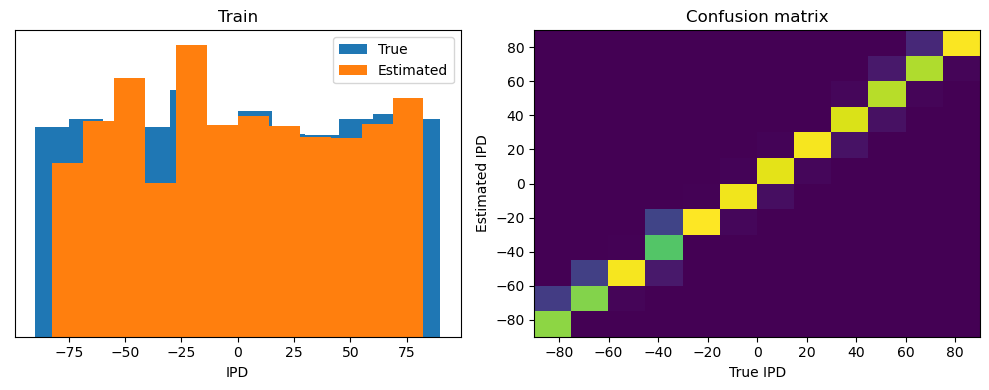

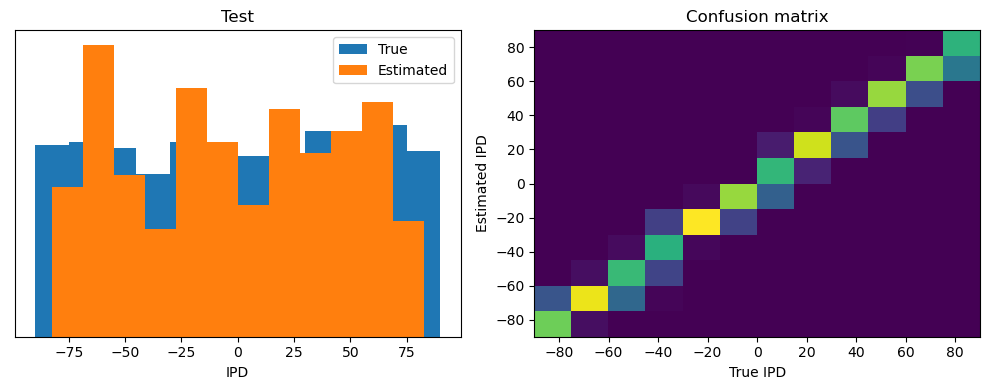

In [96]:
n_testing_batches=32
# Analyse
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2, tau=tau_m)
analyse(ipds, spikes, 'Train', run=run_func)
print(spikes.size())
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)
print(spikes_test.size())

Yes! Performance is much better and now the confusion matrices look more like what you'd expect too. Let's take a look at the weight matrices.

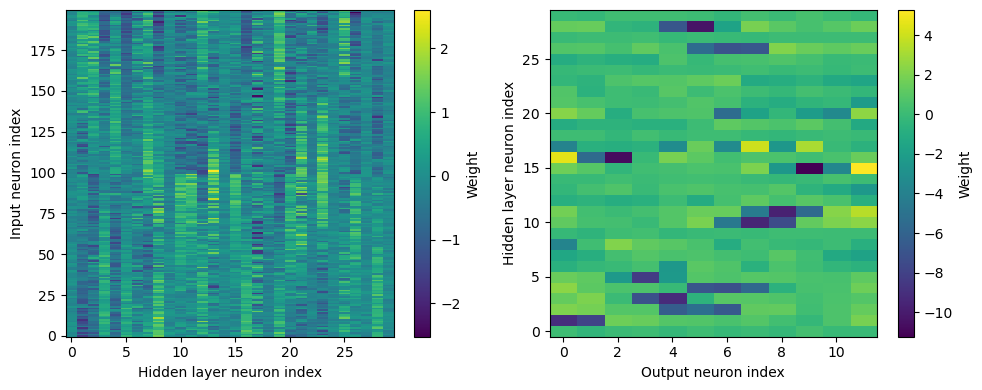

In [97]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.imshow(W1.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.colorbar(label="Weight")
plt.subplot(122)
plt.imshow(W2.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.colorbar(label="Weight")
plt.tight_layout()

Hmm, hard to interpret.


Here's what I've got so far...

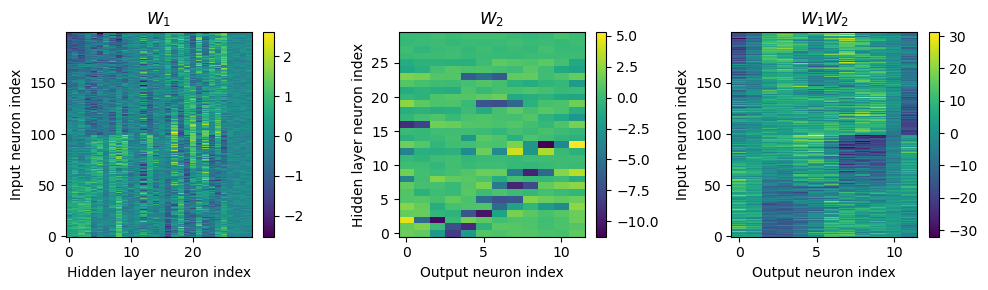

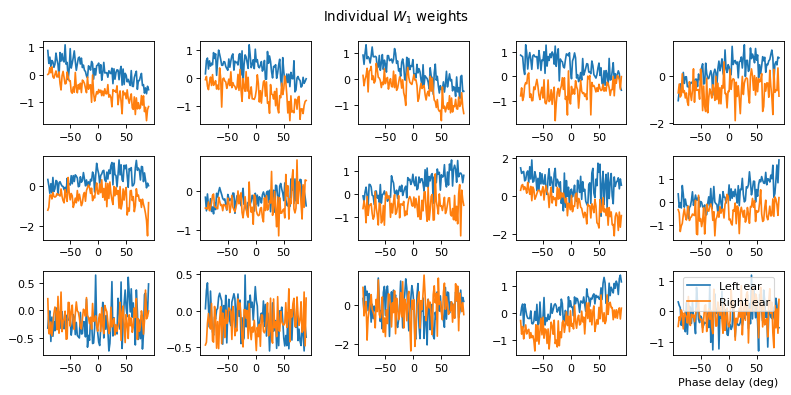

In [98]:
w1 = W1.detach().cpu().numpy()
w2 = W2.detach().cpu().numpy()

# for each column of w1, compute the weighted mean and re-order according to that
A = np.arange(w1.shape[0])[:, None]
weighted_mean = np.mean((A*w1), axis=0)
weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
I = np.argsort(weighted_mean)
w1 = w1[:, I]
w2 = w2[I, :]

# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('$W_1$')
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_2$')
plt.colorbar()
plt.subplot(133)
plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_1W_2$')
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in list(enumerate(I_nz))[:15]:
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual $W_1$ weights")
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()

# Chagning the membrane time constant

In [119]:
def test_accuracy_versus_time_constant():
    
    time_constants = np.linspace(2, 29, 10)
    num_test_samples = 10
    
    test_acc_mean = np.zeros(len(time_constants))
    test_acc_error = np.zeros(len(time_constants))
    for i in trange(len(time_constants)): 
        
        # Train network with fixed membrane time constant
        W1, W2 = train_snn(time_constants[i]*ms)
        
        # Get test accuracy
        n_testing_batches = 64
        run_func = lambda x: snn(x, W1, W2, tau=time_constants[i]*ms)
        
        test_acc_tmp  = np.zeros(num_test_samples)
        for j in range(num_test_samples):
            ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
            test_acc = analyse(ipds_test, spikes_test, 'Test', run=run_func, plot=False)
            test_acc_tmp[j] = test_acc
        
        test_acc_mean[i] = np.mean(test_acc_tmp)
        test_acc_error[i] = np.std(test_acc_tmp)/np.sqrt(10)
    
    
    return time_constants, test_acc_mean, test_acc_error

In [120]:
time_constants, test_acc_mean, test_acc_error = test_accuracy_versus_time_constant()

100%|██████████| 10/10 [11:21<00:00, 68.11s/it]


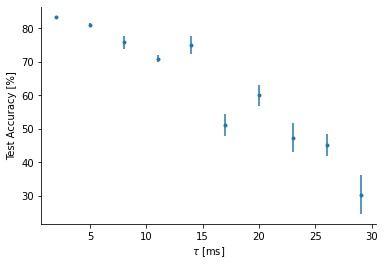

In [122]:
import seaborn as sns
plt.plot(time_constants, test_acc_mean, '.')
plt.errorbar(time_constants, test_acc_mean, test_acc_error, fmt='None')
plt.xlabel(r'$\tau$ [ms]')
plt.ylabel('Test Accuracy [%]')
sns.despine()

The above plot shows the test accuracy vs. the membrane time constant. As exepected it decreases with increasing time constant (small time constants = better for coincidence detection). Each SNN was trained with only 10 epochs. Error bars show the varaition in the test accuracy for different samples of test spikes (i.e., it doesn't show varaition from retraining the model multiple times.) 

What do the weights look like for smaller membrane time constants?

# Weight structure of small membrane time constant ($\tau$ = 2 ms)

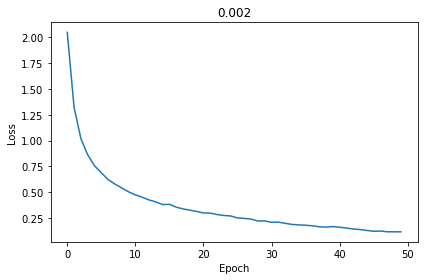

In [126]:
tau_m = 2*ms
W1, W2, loss_hist = train_snn(tau_m, num_epochs=100)

plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
sns.despine()


Chance accuracy level: 8.3%

Train classifier accuracy: 83.9%
Train absolute error: 4.4 deg
torch.Size([4096, 100, 200])

Test classifier accuracy: 84.4%
Test absolute error: 4.5 deg
torch.Size([2048, 100, 200])


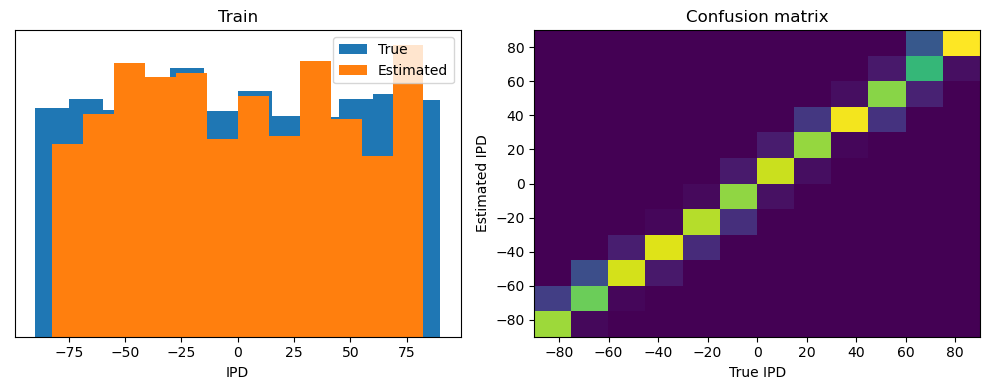

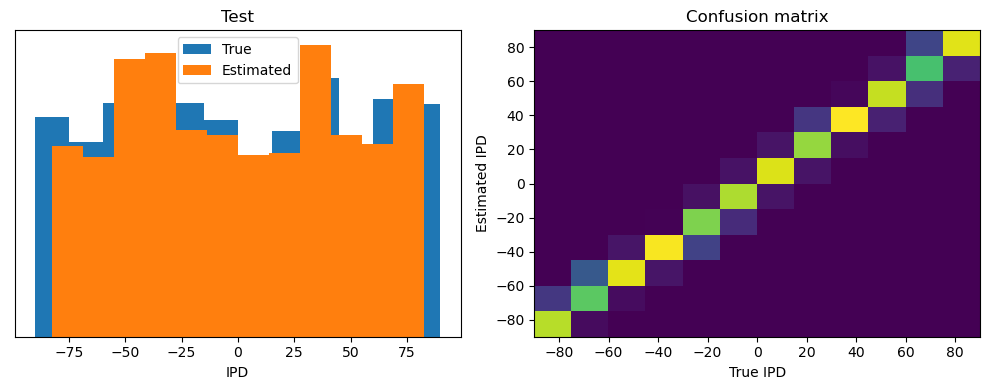

In [127]:
n_testing_batches=32
# Analyse
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2, tau=tau_m)
analyse(ipds, spikes, 'Train', run=run_func, plot=True)
print(spikes.size())
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func, plot=True)
print(spikes_test.size())

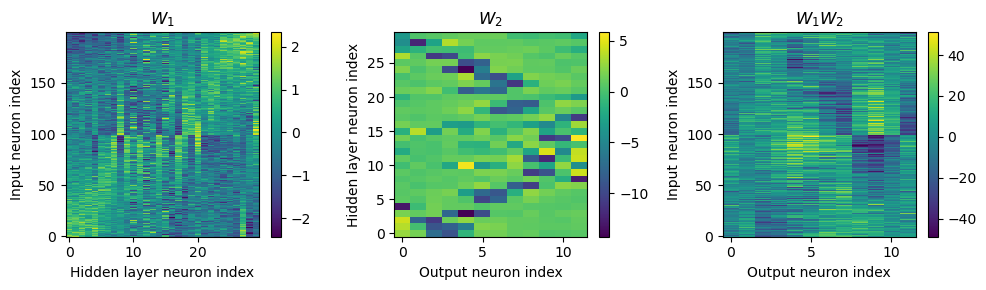

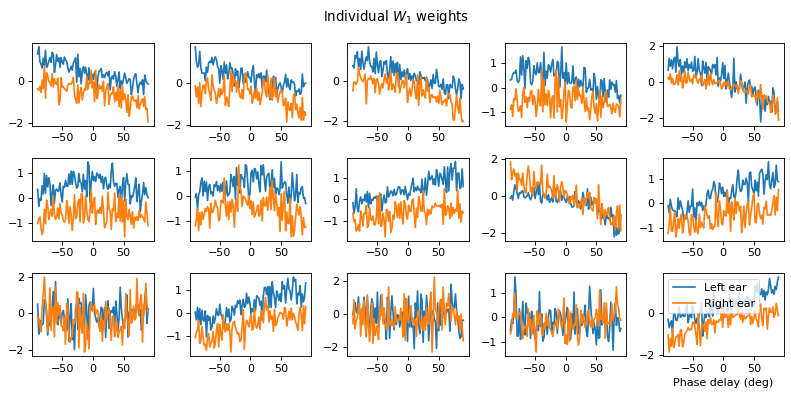

In [128]:
w1 = W1.detach().cpu().numpy()
w2 = W2.detach().cpu().numpy()

# for each column of w1, compute the weighted mean and re-order according to that
A = np.arange(w1.shape[0])[:, None]
weighted_mean = np.mean((A*w1), axis=0)
weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
I = np.argsort(weighted_mean)
w1 = w1[:, I]
w2 = w2[I, :]

# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('$W_1$')
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_2$')
plt.colorbar()
plt.subplot(133)
plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_1W_2$')
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in list(enumerate(I_nz))[:15]:
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual $W_1$ weights")
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()

Both weight matricies appear to have some structure to them that is different from the other notebooks. Not clear to me yet how the network is solving the problem.

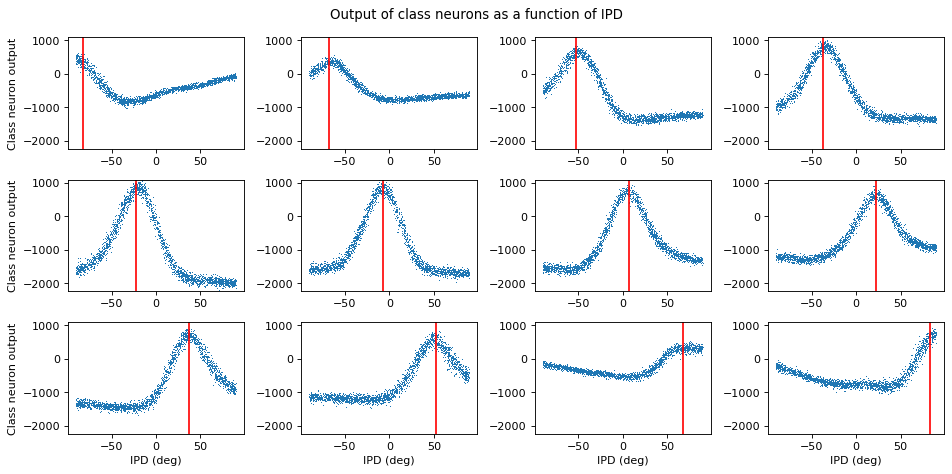

In [130]:
# ipds_test shape (num_samples)
# spikes_test shape (num_samples, duration_steps, 2*anf_per_ear)
all_m = []
all_ipd = []
for x_local, y_local in data_generator(ipds_test, spikes_test):
    output = snn(x_local, W1, W2, tau_m) # shape (batch_size, duration_steps, num_classes)
    m = torch.sum(output, 1) # shape (batch_size, num_classes)
#     m = log_softmax_fn(m)
    all_m.append(m)
    all_ipd.append(y_local)
cls_output = torch.cat(all_m, 0).detach().cpu().numpy() # shape (num_samples, num_classes)
ipds_ = torch.cat(all_ipd).detach().cpu().numpy()

plt.figure(figsize=(12, 6), dpi=80)
for i in range(num_classes):
    plt.subplot(3, 4, i+1)
    plt.plot(ipds_*180/np.pi, cls_output[:, i], ',')
    plt.axvline(continuise(i)*180/np.pi, ls='-', c='r')
    if i//4==2:
        plt.xlabel('IPD (deg)')
    if i%4==0:
        plt.ylabel('Class neuron output')
    plt.ylim(cls_output.min(), cls_output.max())
plt.suptitle("Output of class neurons as a function of IPD")
plt.tight_layout()

Output tuning curves look like they have a stronger peak than before! 

# Future Work

- Optimize the membrane time constant with the connection weights at the same time
- How does this change in performance depend on the neruon model? (e.g., adaptation)
- Do good solutions exists for slow integrators? (large time constants)